In [11]:
from sympy.abc import s
from utils.units import u

gp = 50/((s*u.s)*(0.85*(s*u.s)+1))
gc = 0.031*((s*u.s)+1.808)

In [12]:
from pathlib import Path

out_dir = Path("./out") / "parcial1" / "p1"

In [13]:
from utils.units import basis

nu = basis()

In [14]:
from utils.ctrlsys import s2tf
from control import matlab as m
to_tf = s2tf$(?, s) .. nu.to_numeric$(as_expr=True)

gp_tf = to_tf(gp)
gc_tf = to_tf(gc)
gcl_tf = m.feedback(gp_tf*gc_tf, 1)

In [15]:
from utils.ctrl import nu_stepinfo
from utils.misc import valmap, repr_aligned

step_info = nu_stepinfo(nu, u.s, 1, m.stepinfo(gcl_tf))
valmap(.n(4), step_info) |> repr_aligned |> print

{
    'RiseTime':         0.7908*second,
    'SettlingTime':     2.651*second,
    'SettlingMin':      0.9018,
    'SettlingMax':      1.038,
    'Overshoot':        3.849*percent,
    'Undershoot':       0,
    'Peak':             1.038,
    'PeakTime':         1.814*second,
    'SteadyStateValue': 1.000,
}


In [16]:
from sympy.abc import z
from utils.units.sympy_helpers import without_units
from utils.ratpolys import ratpoly_zpk_form as zpk_form

dt = step_info["RiseTime"]/10
s_dtf = (z-1)/(z*dt)
s_dtf
gc_d = without_units(gc,
    (get_dummy, expr) -> (expr.subs(s, s_dtf).simplify()))

zpk_form(gc_d, z)

0.448062636753259*((z - 0.874910346450367)/z)

In [17]:
from sympy import lambdify

gc_dtf = lambdify([z], gc_d)(m.tf('z'))
gp_dtf = m.c2d(gp_tf, nu[dt], 'zoh')
gcl_dtf = m.feedback(gp_dtf*gc_dtf)

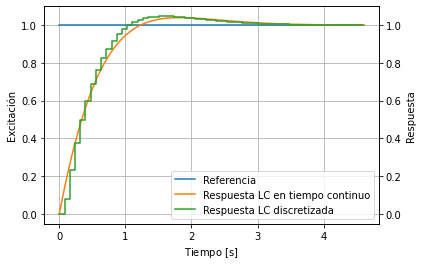

In [21]:
from utils.ctrlsys import step, zoh_stairs
from utils.mpl import io_axes, nu_twinx_axes
import numpy as np

fig, (ax_e, ax_r), next_color, set_gain_and_legend_loc = io_axes()

t, (ref, resp) = step(reversed .. m.step$(gcl_tf))
td = np.arange(min(t), max(t), gcl_dtf.dt)
_, (_, resp_d) = step(reversed .. m.step$(gcl_dtf), t=td)

set_time_title, set_e_title, set_r_title = nu_twinx_axes(
    nu, ax_e, ax_r, u.s, 1, 1
)
ax_e.plot(t, ref, color=next_color(), label="Referencia")
ax_r.plot(t, resp, color=next_color(), label="Respuesta LC en tiempo continuo")
ax_r.plot(*zoh_stairs(td, resp_d), color=next_color(), label="Respuesta LC discretizada")

set_time_title("Tiempo")
set_e_title("Excitación")
set_r_title("Respuesta")
ax_e.grid()
set_gain_and_legend_loc(gcl_tf.dcgain(), "lower right")

fig.savefig(out_dir / "resp_parte1.svg")

In [9]:
from utils.misc import valmap, repr_aligned

my_stepinfo = nu_stepinfo$(nu, u.s, 1) .. m.stepinfo

my_stepinfo(gcl_dtf) |> valmap$(.n(4)) |> repr_aligned |> print

{
    'RiseTime':         0.6326*second,
    'SettlingTime':     2.451*second,
    'SettlingMin':      0.9160,
    'SettlingMax':      1.046,
    'Overshoot':        4.582*percent,
    'Undershoot':       0,
    'Peak':             1.046,
    'PeakTime':         1.582*second,
    'SteadyStateValue': 1.000,
}


In [10]:
import sympy as sp
from utils.ctrl import siso_numden

e, u_ = map(sp.Function, ["e", "u"])
k = sp.Symbol("k")

def recursive_eq(num, den, in_, out, k):
    den_offset = len(num)-len(den)
    a0, *den_tail = den
    sum_in = sum(a*in_(k-i+den_offset) for i, a in enumerate(num))
    sum_out = sum(a*out(k-i-1) for i, a in enumerate(den_tail))
    return sp.Eq(out(k), (sum_in-sum_out)/a0)
    
num, den = siso_numden(gc_dtf)
recursive_eq(num, den, e, u_, k).n(4)

Eq(u(k), 0.4481*e(k) - 0.392*e(k - 1))

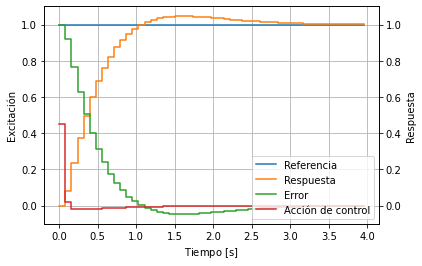

In [11]:
from utils.ctrlsys import step, zoh_stairs
from utils.mpl import io_axes, nu_twinx_axes
import numpy as np

fig, (ax_e, ax_r), next_color, set_gain_and_legend_loc = io_axes()

td = np.arange(0, nu[4*u.s], gcl_dtf.dt)
_, (ref, resp_d) = step(reversed .. m.step$(gcl_dtf), t=td)
_, (ref, ctrl_d) = step(reversed .. m.step$(m.feedback(gc_dtf, gp_dtf)), t=td)

set_time_title, set_e_title, set_r_title = nu_twinx_axes(
    nu, ax_e, ax_r, u.s, 1, 1
)
ax_e.plot(td, ref, color=next_color(), label="Referencia")
ax_r.plot(*zoh_stairs(td, resp_d), color=next_color(), label="Respuesta")
ax_r.plot(*zoh_stairs(td, ref-resp_d), color=next_color(), label="Error")
ax_r.plot(*zoh_stairs(td, ctrl_d), color=next_color(), label="Acción de control")

set_time_title("Tiempo")
set_e_title("Excitación")
set_r_title("Respuesta")
ax_e.grid()
set_gain_and_legend_loc(gcl_tf.dcgain(), "lower right")

fig.savefig(out_dir / "resp_parte1_signals.svg")

In [12]:
gzohinv = 2*z/(z+1)
gzohinv_dtf = lambdify([z], gzohinv)(m.tf("z"))
gzohinv_dtf

gclc_dtf = m.feedback(gzohinv_dtf * gc_dtf * gp_dtf)
gclc_dtf

TransferFunction(array([ 0.15982496,  0.01511245, -0.13556295,  0.        ]), array([ 1.        , -0.7513378 , -0.98488755,  0.77559981,  0.        ]), 0.0010690229794598385)

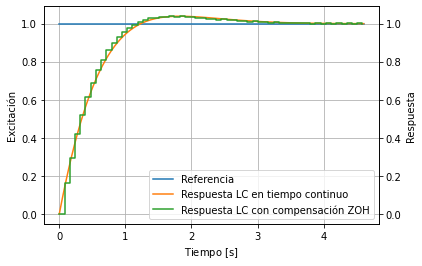

In [13]:
from utils.ctrlsys import step, zoh_stairs
from utils.mpl import io_axes, nu_twinx_axes
import numpy as np

fig, (ax_e, ax_r), next_color, set_gain_and_legend_loc = io_axes()

t, (ref, resp) = step(reversed .. m.step$(gcl_tf))
td = np.arange(min(t), max(t), gcl_dtf.dt)
#_, (_, resp_d) = step(reversed .. m.step$(gcl_dtf), t=td)
_, (_, resp_d) = step(reversed .. m.step$(gclc_dtf), t=td)

set_time_title, set_e_title, set_r_title = nu_twinx_axes(
    nu, ax_e, ax_r, u.s, 1, 1
)
ax_e.plot(t, ref, color=next_color(), label="Referencia")
ax_r.plot(t, resp, color=next_color(), label="Respuesta LC en tiempo continuo")
ax_r.plot(*zoh_stairs(td, resp_d), color=next_color(), label="Respuesta LC con compensación ZOH")

set_time_title("Tiempo")
set_e_title("Excitación")
set_r_title("Respuesta")
ax_e.grid()
set_gain_and_legend_loc(gcl_tf.dcgain(), "lower right")

fig.savefig(out_dir / "resp_parte1_compensado.svg")

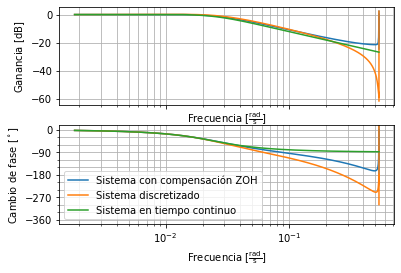

In [14]:
from utils.mpl import set_datalim, nu_sharex_axes
from utils.ctrl import bode_axes

fig, (ax_gain, ax_phase), add_bode_, add_deg_locator = bode_axes()

add_bode = add_bode_$(deg=False, dB=True)

_, _, w = add_bode(gclc_dtf, label="Sistema con compensación ZOH")
add_bode(gcl_dtf, label="Sistema discretizado", omega=w)
add_bode(gcl_tf, label="Sistema en tiempo continuo", omega=w)

add_deg_locator(90)

nu_sharex_axes(nu, ax_phase, ax_gain,
    ("Frecuencia", u.rad/u.s),
    ("Cambio de fase", u.deg),
    ("Ganancia", 1),
    y2_in_db=True)

ax_gain.grid(which='both')
ax_phase.grid(which='both')
set_datalim(ax_phase, y=(-nu[360*u.deg], 0))

ax_phase.legend(); None

fig.savefig(out_dir / "resp_parte1_compensado_bode.svg")

In [15]:
from sympy import symbols
kc, a = symbols("K_c a", real=True, positive=True)
gcd = kc*(z-a)/z

ts = 3*u.s
mp = 5*u.percent

In [16]:
from utils.ctrlsys import pole_specs

_, dp_s = pole_specs(nu[ts], nu[mp])
nu.to_symb(u.Hz, dp_s).n(4)

hertz*(-1.304 + 1.367*I)

In [17]:
from utils.ctrlsys import z_map
dp = z_map(dp_s, nu[gp_dtf.dt])
sp.sympify(dp).n(4)

0.8968 + 0.09735*I

In [18]:
gdelay_dtf = 1/m.tf("z")

gls = {
    "atraso del muestreador": gdelay_dtf,
    "planta": gp_dtf
}

In [19]:
from IPython.display import display

def side_effect(f, value):
    f(value)
    return value

pprint = side_effect$(display)

In [20]:
from itertools import starmap
from utils.ratpolys import numden2ratpoly

def rlocus_cond(dp, z, ratpoly):
    return ratpoly.subs(z, dp)+1

gpd = numden2ratpoly$(*siso_numden(gp_dtf))(z)

In [21]:
from utils.math import sp_reim
kc_, a_ = sp.nsolve(
    sp_reim(rlocus_cond(dp, z, gcd*gpd*1/z)),
    [kc, a], [1, .5]) |> map$(float)

kc_, a_

(0.31611680268188946, 0.85033543051807)

In [23]:
from utils.ctrlsys import autotune

kc_, a_ = pprint(
    autotune(
        {kc: kc_, a: a_},
        z, m.tf("z"),
        gcd,
        nu[mp]*.95, nu[ts]*.95,
        gp_dtf*gdelay_dtf, 1, iter=10)
)

array([0.33650607, 0.88049715])

In [24]:
tftot = (gcd*gpd*1/z).subs(kc, kc_).subs(a, a_)

In [25]:
gcd_dtf = lambdify([z], gcd.subs(a, a_).subs(kc, kc_))(m.tf('z'))
gcd_dtf

gcld_dtf = m.feedback(reduce((*), gls.values()) * gcd_dtf)

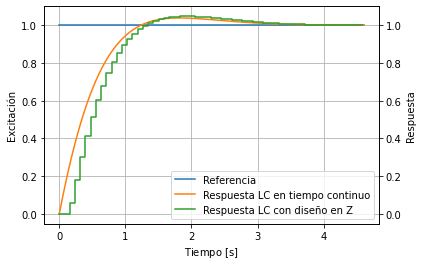

In [26]:
from utils.ctrlsys import step, zoh_stairs
from utils.mpl import io_axes, nu_twinx_axes
import numpy as np

fig, (ax_e, ax_r), next_color, set_gain_and_legend_loc = io_axes()

t, (ref, resp) = step(reversed .. m.step$(gcl_tf))
td = np.arange(min(t), max(t), gcl_dtf.dt)
#_, (_, resp_d) = step(reversed .. m.step$(gcl_dtf), t=td)
_, (_, resp_d) = step(reversed .. m.step$(gcld_dtf), t=td)

set_time_title, set_e_title, set_r_title = nu_twinx_axes(
    nu, ax_e, ax_r, u.s, 1, 1
)
ax_e.plot(t, ref, color=next_color(), label="Referencia")
ax_r.plot(t, resp, color=next_color(), label="Respuesta LC en tiempo continuo")
ax_r.plot(*zoh_stairs(td, resp_d), color=next_color(), label="Respuesta LC con diseño en Z")

set_time_title("Tiempo")
set_e_title("Excitación")
set_r_title("Respuesta")
ax_e.grid()
set_gain_and_legend_loc(gcl_tf.dcgain(), "lower right")

fig.savefig(out_dir / "resp_parte1_zd.svg")

In [29]:
my_stepinfo(gcld_dtf
    ) |> valmap$(.n(4)) |> repr_aligned |> print

{
    'RiseTime':         0.7908*second,
    'SettlingTime':     2.926*second,
    'SettlingMin':      0.9271,
    'SettlingMax':      1.048,
    'Overshoot':        4.75*percent,
    'Undershoot':       0,
    'Peak':             1.048,
    'PeakTime':         1.898*second,
    'SteadyStateValue': 1.000,
}


In [28]:
from utils.ctrl import sys_deu

sys_deu(gcld_dtf, nu, 1, 1)

TransferFunction(array([ 0.06001624,  0.00533961, -0.05123062]), array([ 1.        , -1.91116276,  0.971179  ,  0.00533961, -0.05123062]), 0.07907867996141164)